
--- Memulai Hyperparameter Tuning untuk Argon2 ---
Menguji m=65536, t=2: Rata-rata waktu hashing = 84.17 ms
Menguji m=65536, t=3: Rata-rata waktu hashing = 103.66 ms
Menguji m=65536, t=4: Rata-rata waktu hashing = 134.51 ms
Menguji m=65536, t=5: Rata-rata waktu hashing = 152.14 ms
Menguji m=131072, t=2: Rata-rata waktu hashing = 171.75 ms
Menguji m=131072, t=3: Rata-rata waktu hashing = 207.51 ms
Menguji m=131072, t=4: Rata-rata waktu hashing = 261.72 ms
Menguji m=131072, t=5: Rata-rata waktu hashing = 309.54 ms
Menguji m=262144, t=2: Rata-rata waktu hashing = 337.25 ms
Menguji m=262144, t=3: Rata-rata waktu hashing = 434.50 ms
Menguji m=262144, t=4: Rata-rata waktu hashing = 521.84 ms
Menguji m=262144, t=5: Rata-rata waktu hashing = 617.47 ms

--- Tuning Selesai ---
Parameter optimal ditemukan: {'time_cost': 4, 'memory_cost': 131072, 'parallelism': 4}

--- Memulai Pengujian Kinerja dengan Parameter Optimal ---

--- Hasil Akhir Pengujian Kinerja ---
Jumlah sampel diuji: 1000
Parameter

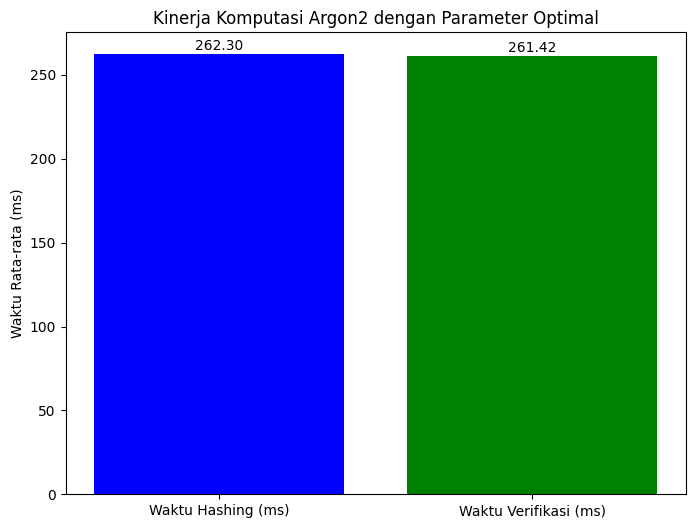

In [1]:
import time
import argon2
import os
import psutil
import matplotlib.pyplot as plt
import concurrent.futures

# --- Konfigurasi Awal ---
CONFIG = {
    "num_samples_for_testing": 1000,   # Jumlah password untuk diuji setelah tuning
    "num_samples_for_tuning": 100,      # Jumlah password untuk proses tuning (lebih kecil agar cepat)
    "tuning_time_target_ms": 300,       # Target waktu eksekusi dalam milidetik (0.3 detik)
    "num_threads": 4,
    "database_path": "/kaggle/input/kaonashi14m/kaonashi14m.txt"
}

# --- Fungsi-Fungsi ---

def load_passwords(file_path, num_samples):
    """Memuat password dari dataset."""
    passwords = []
    try:
        with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
            # Mengambil sampel acak sederhana untuk tuning, bisa diganti dengan metode lain
            for i, line in enumerate(file):
                if i >= num_samples:
                    break
                passwords.append(line.strip())
    except FileNotFoundError:
        print(f"Error: File {file_path} tidak ditemukan.")
    return passwords

def tune_argon2_parameters(passwords_for_tuning, time_target_ms):
    """
    Mencari parameter Argon2 terbaik secara dinamis.
    Fungsi ini mensimulasikan proses kalibrasi periodik di server.
    """
    print("\n--- Memulai Hyperparameter Tuning untuk Argon2 ---")
    
    # Nilai awal yang akan diuji
    time_costs = [2, 3, 4, 5]
    memory_costs = [65536, 131072, 262144] # dalam KiB
    
    best_params = {'time_cost': 1, 'memory_cost': 16, 'parallelism': 2}
    highest_security_level = 0

    for mem in memory_costs:
        for time_c in time_costs:
            try:
                ph = argon2.PasswordHasher(time_cost=time_c, memory_cost=mem, parallelism=CONFIG['num_threads'])
                
                start_time = time.time()
                for p in passwords_for_tuning:
                    ph.hash(p)
                end_time = time.time()

                avg_time_ms = ((end_time - start_time) / len(passwords_for_tuning)) * 1000
                print(f"Menguji m={mem}, t={time_c}: Rata-rata waktu hashing = {avg_time_ms:.2f} ms")

                # Cek jika parameter ini masih dalam batas target waktu dan lebih aman
                if avg_time_ms <= time_target_ms:
                    current_security_level = mem * time_c
                    if current_security_level > highest_security_level:
                        highest_security_level = current_security_level
                        best_params['time_cost'] = time_c
                        best_params['memory_cost'] = mem
                        best_params['parallelism'] = CONFIG['num_threads']

            except Exception as e:
                print(f"Gagal menguji parameter m={mem}, t={time_c}: {e}")

    print("\n--- Tuning Selesai ---")
    print(f"Parameter optimal ditemukan: {best_params}")
    return best_params

def test_argon2_performance(passwords, params):
    """Menguji kinerja hashing dan verifikasi dengan parameter yang diberikan."""
    ph = argon2.PasswordHasher(
        time_cost=params['time_cost'],
        memory_cost=params['memory_cost'],
        parallelism=params['parallelism']
    )
    
    # 1. Tes Hashing
    start_hashing = time.time()
    hashes = [ph.hash(p) for p in passwords]
    end_hashing = time.time()
    total_hashing_time = end_hashing - start_hashing
    avg_hashing_time = (total_hashing_time / len(passwords)) * 1000

    # 2. Tes Verifikasi
    start_verifying = time.time()
    for i in range(len(passwords)):
        ph.verify(hashes[i], passwords[i])
    end_verifying = time.time()
    total_verifying_time = end_verifying - start_verifying
    avg_verifying_time = (total_verifying_time / len(passwords)) * 1000
    
    return avg_hashing_time, avg_verifying_time


# --- Alur Eksekusi Utama ---

# 1. Muat dataset
passwords_for_tuning = load_passwords(CONFIG['database_path'], CONFIG['num_samples_for_tuning'])
passwords_for_testing = load_passwords(CONFIG['database_path'], CONFIG['num_samples_for_testing'])

if not passwords_for_tuning or not passwords_for_testing:
    print("Tidak dapat melanjutkan karena dataset tidak dimuat.")
else:
    # 2. Lakukan tuning untuk mendapatkan parameter optimal
    optimal_params = tune_argon2_parameters(passwords_for_tuning, CONFIG['tuning_time_target_ms'])

    # 3. Jalankan pengujian utama dengan parameter optimal
    print("\n--- Memulai Pengujian Kinerja dengan Parameter Optimal ---")
    avg_hash_time, avg_verify_time = test_argon2_performance(passwords_for_testing, optimal_params)

    # 4. Tampilkan hasil
    print("\n--- Hasil Akhir Pengujian Kinerja ---")
    print(f"Jumlah sampel diuji: {len(passwords_for_testing)}")
    print(f"Parameter yang digunakan: {optimal_params}")
    print(f"Rata-rata waktu HASHING per password: {avg_hash_time:.4f} ms")
    print(f"Rata-rata waktu VERIFIKASI per password: {avg_verify_time:.4f} ms")

    # 5. Visualisasi sederhana
    labels = ['Waktu Hashing (ms)', 'Waktu Verifikasi (ms)']
    values = [avg_hash_time, avg_verify_time]

    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color=['blue', 'green'])
    plt.ylabel('Waktu Rata-rata (ms)')
    plt.title('Kinerja Komputasi Argon2 dengan Parameter Optimal')
    for i, v in enumerate(values):
        plt.text(i, v + 0.5, f"{v:.2f}", ha='center', va='bottom')
    plt.show()

In [2]:
import time
import argon2
import os
import random

# --- Konfigurasi Pengujian ---
CONFIG = {
    "num_targets": 10,                 # Jumlah hash yang akan diserang
    "dictionary_size": 100,           # Jumlah password dalam kamus penyerang
    "database_path": "/kaggle/input/kaonashi14m/kaonashi14m.txt" # Sesuaikan path ini
}

# --- Parameter Optimal Argon2 yang Anda Temukan ---
# (Ini harus sama dengan hasil tuning Anda sebelumnya)
ARGON2_PARAMS = {
    'time_cost': 4,
    'memory_cost': 131072,
    'parallelism': 2
}

# --- Fungsi-Fungsi ---

def load_passwords(file_path, num_samples):
    """Memuat password dari dataset."""
    passwords = []
    try:
        with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
            all_lines = file.readlines()
            # Ambil sampel acak untuk target dan kamus
            if len(all_lines) < num_samples:
                print(f"Peringatan: Ukuran dataset lebih kecil dari jumlah sampel yang diminta.")
                return [line.strip() for line in all_lines]
            
            sampled_lines = random.sample(all_lines, num_samples)
            passwords = [line.strip() for line in sampled_lines]

    except FileNotFoundError:
        print(f"Error: File {file_path} tidak ditemukan.")
    return passwords

# --- ALUR EKSEKUSI UTAMA ---

if __name__ == '__main__':
    # 1. Persiapan
    ph = argon2.PasswordHasher(**ARGON2_PARAMS)
    
    # Muat password untuk dijadikan target dan kamus
    target_passwords = load_passwords(CONFIG['database_path'], CONFIG['num_targets'])
    dictionary = load_passwords(CONFIG['database_path'], CONFIG['dictionary_size'])

    if not target_passwords or not dictionary:
        print("Gagal memuat dataset. Program berhenti.")
    else:
        # Buat "database yang dicuri" (daftar hash)
        target_hashes = [ph.hash(p) for p in target_passwords]
        print(f"--- Persiapan Selesai ---")
        print(f"Jumlah Target Hash: {len(target_hashes)}")
        print(f"Ukuran Kamus Penyerang: {len(dictionary)}")
        print(f"Total Percobaan Verifikasi: {len(target_hashes) * len(dictionary):,}")
        
        # 2. Mulai Simulasi Serangan
        print("\n--- Memulai Simulasi Serangan Kamus ---")
        start_time = time.time()

        cracked_passwords = 0
        
        # Untuk setiap hash di database curian...
        for i, target_hash in enumerate(target_hashes):
            # ...coba setiap password di kamus
            for password_guess in dictionary:
                try:
                    # ph.verify() akan melakukan hashing dan perbandingan
                    # Ia akan berhasil jika tebakan benar, atau melempar exception jika salah
                    ph.verify(target_hash, password_guess)
                    # Jika kode sampai di sini, artinya password berhasil dipecahkan
                    print(f"!!! Password DITEMUKAN untuk hash #{i+1}: '{password_guess}'")
                    cracked_passwords += 1
                except argon2.exceptions.VerifyMismatchError:
                    # Ini adalah hasil yang diharapkan, tebakan salah
                    continue
        
        end_time = time.time()
        total_time = end_time - start_time
        
        # 3. Tampilkan Hasil
        print("\n--- Hasil Akhir Simulasi ---")
        print(f"Total waktu simulasi: {total_time:.2f} detik")
        print(f"Password yang berhasil dipecahkan: {cracked_passwords}/{len(target_hashes)}")
        
        total_checks = len(target_hashes) * len(dictionary)
        if total_time > 0:
            hashes_per_second = total_checks / total_time
            print(f"Kecepatan penyerang (perkiraan): {hashes_per_second:.2f} hash/detik")

--- Persiapan Selesai ---
Jumlah Target Hash: 10
Ukuran Kamus Penyerang: 100
Total Percobaan Verifikasi: 1,000

--- Memulai Simulasi Serangan Kamus ---

--- Hasil Akhir Simulasi ---
Total waktu simulasi: 377.53 detik
Password yang berhasil dipecahkan: 0/10
Kecepatan penyerang (perkiraan): 2.65 hash/detik
